# 2D Soccer Simulation League Expected Goals Model

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Loading database
In this section, we load the database generated files to use in the model

In [4]:
dir = os.getcwd()
with open(os.path.join(dir, 'database/data/database_2019+2021.csv')) as f:
    data = pd.read_csv(f)

In [5]:
data.tail()

,x,y,distance,angle,players_in_between,goal
5984,17.1540,-22.4286,41.861460,0.283130,2,0
5985,33.8547,-9.0582,20.729163,0.601883,9,0
5986,6.8481,-30.9291,55.142590,0.210771,2,0
5987,2.2565,-4.2122,50.419757,0.275377,2,0
5988,5.0417,3.4721,47.585142,0.291790,3,0


In [6]:
shots_model = data.copy()
for i,shot in shots_model.iterrows():
  shots_model.at[i,'x']=52.5-shot['x']
  shots_model.at[i,'y']=34+shot['y']

In [7]:
shots_model.tail()

,x,y,distance,angle,players_in_between,goal
5984,35.3460,11.5714,41.861460,0.283130,2,0
5985,18.6453,24.9418,20.729163,0.601883,9,0
5986,45.6519,3.0709,55.142590,0.210771,2,0
5987,50.2435,29.7878,50.419757,0.275377,2,0
5988,47.4583,37.4721,47.585142,0.291790,3,0


In [8]:
goals_only = shots_model[data['goal']==1]
shots_only = shots_model[shots_model['goal'] != 1]
goals_only.tail()

,x,y,distance,angle,players_in_between,goal
5966,7.1671,25.3688,11.218954,0.918672,2,1
5969,12.8738,27.5163,14.414336,0.849763,2,1
5971,10.1892,27.7376,11.959827,0.989305,2,1
5974,12.2084,32.1331,12.350318,1.027404,3,1
5978,7.8758,27.5992,10.148816,1.116985,3,1


In [9]:
len(goals_only), len(shots_model)

(1718, 5989)

## Exploratory data analysis
To help understand how the data is distributed we make many plots with different features

In [10]:
from matplotlib.patches import Arc

def createGoalMouth(fig_size=(10, 6)):
    """
    Creates goal mouth fig
    """
    fig, ax=plt.subplots(1,1,figsize=fig_size)

    linecolor='black'

    #Pitch Outline & Centre Line
    plt.plot([0,68],[0,0], color=linecolor)
    plt.plot([68,68],[52.5,0], color=linecolor)
    plt.plot([0,0],[52.5,0], color=linecolor)
    
    #Left Penalty Area
    plt.plot([13.84,13.84],[0,16.5],color=linecolor)
    plt.plot([13.84,54.16],[16.5,16.5],color=linecolor)
    plt.plot([54.16,54.16],[0,16.5],color=linecolor)    
    
    #Goal
    plt.plot([41.01,41.01],[-2,0],color=linecolor)
    plt.plot([26.99,41.01],[-2,-2],color=linecolor)
    plt.plot([26.99,26.99],[0,-2],color=linecolor)
    
    #Prepare Circles
    leftPenSpot = plt.Circle((68/2,11),0.4,color=linecolor)
    
    #Draw Circles
    ax.add_patch(leftPenSpot)

    #Prepare Arcs
    leftArc = Arc((34,11),height=18,width=18,angle=0,theta1=38,theta2=142,color=linecolor)
    
    #Draw Arcs
    ax.add_patch(leftArc)
        
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax

Analyzing frequency of shots and goals per position on the pitch

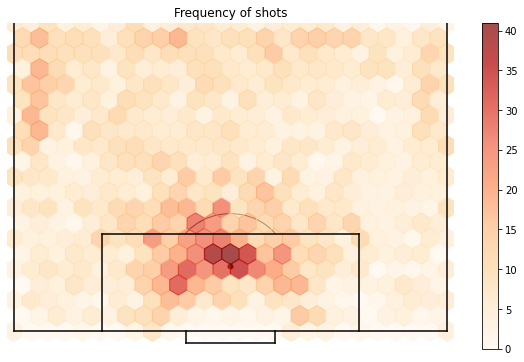

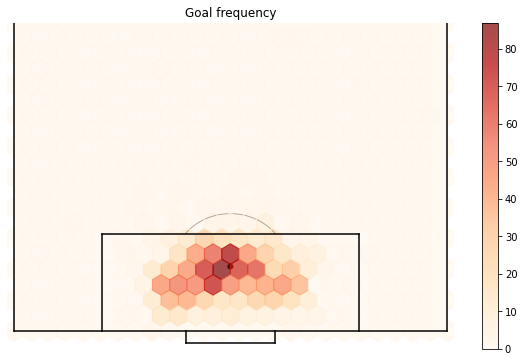

In [11]:
(fig,ax) = createGoalMouth()
pos=ax.hexbin(data =shots_only, x='y', y='x',zorder=1,cmap='OrRd',gridsize=(25,10),alpha=.7,extent=(0,68,0,52.5))
ax.set_xlim(-1, 69)
ax.set_ylim(-3,52.5)
plt.colorbar(pos, ax=ax)
ax.set_title('Frequency of shots')

fig, ax = createGoalMouth()
pos=ax.hexbin(data = goals_only,x='y', y='x',zorder=1,cmap='OrRd',gridsize=(25,10),alpha=.7,extent=(0,68,0,52.5))
ax.set_xlim(-1, 69)
ax.set_ylim(-3,52.5)
plt.colorbar(pos, ax=ax)
plt.axis('off')
ax.set_title('Goal frequency')

plt.show()

Plotting the first 750 shots and 250 goals to visualize the probabilities

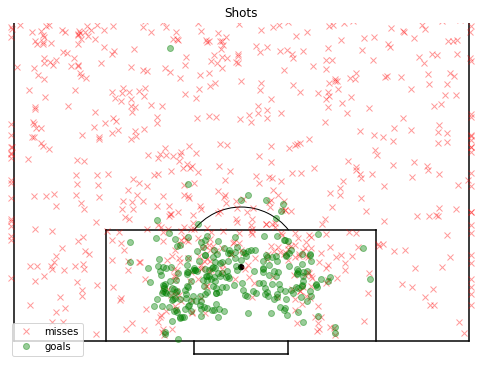

In [12]:
(fig,ax) = createGoalMouth((6.8,5.25))
shots_1000 = shots_only[0:750]
goals_1000 = goals_only[0:250]
ax.plot(shots_1000['y'], shots_1000['x'], 'rx', label='misses', alpha=0.4)
ax.plot(goals_1000['y'], goals_1000['x'], 'go', label='goals', alpha=0.4)
ax.set_title('Shots')
ax.legend()
plt.xlim((-1,69))
plt.ylim((-3,47.5))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Building the model
We will use a model based on the logistic function, very useful to this kind of problema as we are interested in a probability of goals given some variables and the function outputs a value between 0 and 1.

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

Showing first 200 shots results based on angle

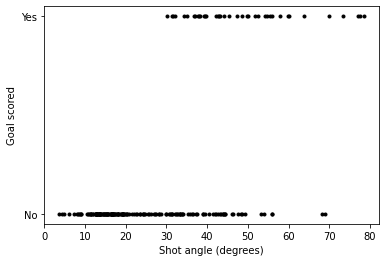

In [15]:
shots_200=shots_model.iloc[:200]

#Plot first 200 shots goal angle
fig,ax=plt.subplots(num=1)
ax.plot(shots_200['angle']*180/np.pi, shots_200['goal'], linestyle='none', marker= '.', color='black')
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

Show empirically how goal angle predicts probability of scoring


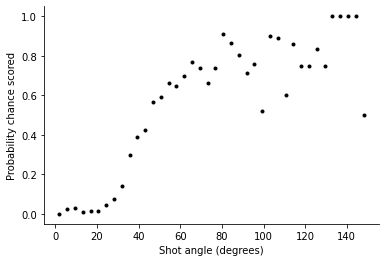

In [17]:
shotcount_dist=np.histogram(shots_model['angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

After analyzing the dataset and building many models, we decided to build the model based on the variables angle, distance and players between the shooter and the goal, since those three gave us the most predictive power (according to p-values from the model built).

In [18]:
# A general model for fitting goal probability
# List the model variables you want here
model_variables = ['angle','distance', 'players_in_between']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#Fit the model
test_model = smf.glm(formula="goal ~ " + model, data=shots_model, family=sm.families.Binomial()).fit()
print(test_model.summary())        
model_params=test_model.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                 5989
Model:                            GLM   Df Residuals:                     5985
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1840.0
Date:                Fri, 04 Mar 2022   Deviance:                       3680.1
Time:                        12:43:52   Pearson chi2:                 1.41e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4424
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.6786      0

In [19]:
model_params

Intercept             2.678591
angle                 1.788279
distance             -0.164496
players_in_between   -0.671407
dtype: float64

Useful function to return xG from angle, distance and players in between

In [21]:
def calculate_xG(sh): 
   bsum=model_params[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+model_params[i+1]*sh[v]
   xG = 1 - 1/(1+np.exp(bsum)) 
   return xG   

In [22]:
#Add an xG to the dataframe
xG=shots_model.apply(calculate_xG, axis=1)
shots_model = shots_model.assign(xG=xG)
shots_model

,x,y,distance,angle,players_in_between,goal,xG
0,52.1661,29.6488,52.347253,0.265364,5,0,0.000148
1,20.1485,21.3749,23.777199,0.500704,3,0,0.086948
2,14.3825,24.8187,17.063194,0.694654,2,1,0.443046
3,42.2679,4.5545,51.513230,0.223721,4,0,0.000309
4,41.3071,5.7849,50.023678,0.231823,3,0,0.000784
...,...,...,...,...,...,...,...
5984,35.3460,11.5714,41.861460,0.283130,2,0,0.006407
5985,18.6453,24.9418,20.729163,0.601883,9,0,0.003343
5986,45.6519,3.0709,55.142590,0.210771,2,0,0.000637
5987,50.2435,29.7878,50.419757,0.275377,2,0,0.001554


Final results: showing xG from position on the pitch!

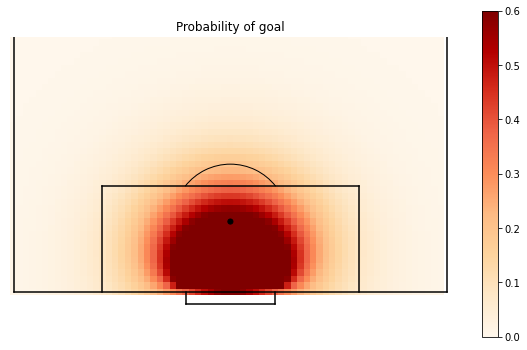

In [24]:
#Create a 2D map of xG
pgoal_2d=np.zeros((52,68))
for x in range(52):
    for y in range(68):
        sh=dict()
        a = np.arctan(14.02 *x /(x**2 + abs(y-68/2)**2 - (7.01)**2))
        if a<0:
            a = np.pi + a
        sh['angle'] = a
        sh['distance'] = np.sqrt(x**2 + abs(y-68/2)**2)
        sh['players_in_between'] = 3
        
        pgoal_2d[x,y] = calculate_xG(sh)

(fig,ax) = createGoalMouth()
pos=ax.imshow(pgoal_2d, aspect='auto',cmap=plt.cm.OrRd, vmin=0, vmax=0.6)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((-1,69))
plt.ylim((-3,40))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Additionally, we show also the xG contours

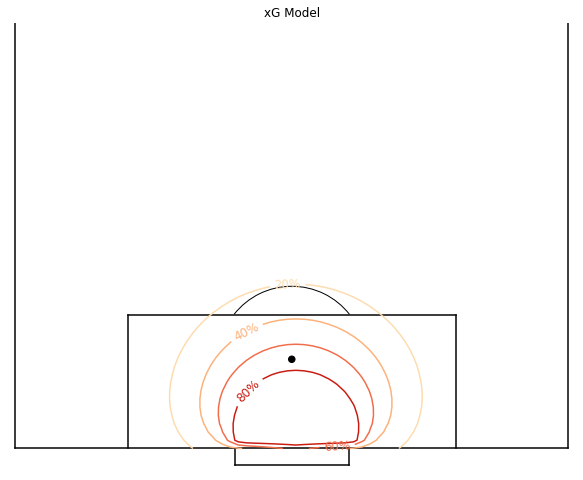

In [26]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

x1 = np.linspace(0, 52 , 52)
x_0 = np.linspace(0, 68, 68)

fig, ax = createGoalMouth((10.2,8.28))

CS = ax.contour(x_0,x1, pgoal_2d, alpha=1, cmap='OrRd',levels=5)

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()


# Recast levels to new class
CS.levels = [nf(val*100) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r\%%'
else:
    fmt = '%r%%'
ax.clabel(CS, CS.levels[0::1],inline=True, fmt=fmt, fontsize=12)

ax.set_title('xG Model')

ax.set_xlim(-1,69)
ax.set_ylim(-3,52.5)
plt.show()

## Evaluating the model's predictive power


### Log likelihood
The likelihood function (often simply called the likelihood) describes the joint probability of the observed data as a function of the parameters of the chosen statistical model. In general, the closer to 1 the value is, the greater the predictive power of the model.

In [27]:
#Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="goal ~ 1 ", data=shots_model, family=sm.families.Binomial()).fit()
1-test_model.llf/null_model.llf

0.4873548492904852

### ROC Curve
A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

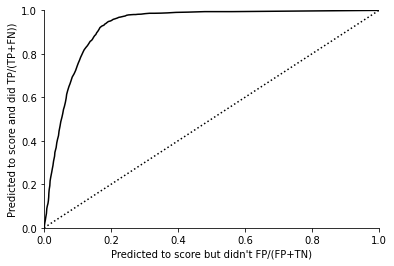

In [28]:
#ROC curve
numobs=100
TP=np.zeros(numobs)
FP=np.zeros(numobs)
TN=np.zeros(numobs)
FN=np.zeros(numobs)


for i,threshold in enumerate(np.arange(0,1,1/numobs)):
    for j,shot in shots_model.iterrows():
        if (shot['goal']==1): 
            if(shot['xG']>threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['goal']==0): 
            if(shot['xG']>threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1
     

fig,ax=plt.subplots(num=1)
ax.plot(FP/(FP+TN), TP/(TP+FN), color='black')
ax.plot([0,1], [0,1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00,1.00))
plt.xlim((0.00,1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Sources:
* [Friends of Tracking 1](https://www.youtube.com/watch?v=bpjLyFyLlXs)
* [Friends of Tracking 2](https://www.youtube.com/watch?v=wHOgINJ5g54)
* [Friends of Tracking 3](https://www.youtube.com/watch?v=310_eW0hUqQ)
* [Tifo Football](https://www.youtube.com/watch?v=zSaeaFcm1SY)
* [Bundesliga YT channel](https://www.youtube.com/watch?v=_vGhocyvKhA)
* [Football Made Simple](https://youtu.be/CCGtjXR4GAk)
* [The Geometry of Shooting | by David Sumpter | Medium](https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760)
* [Friends-of-Tracking-Data-FoTD/SoccermaticsForPython: This repo is dedicated for people getting started with Python using the concepts derived from the book Soccermatics (Sumpter 2016)](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython)
* [eddwebster/xG_Model_Workflow: Comprehensive Guide to explaining, creating and using an xG model](https://github.com/eddwebster/xG_Model_Workflow)